In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from dotenv import load_dotenv
from pandas.plotting import parallel_coordinates
import importlib
import plotly.express as px
import plotly.graph_objects as go
import os
import glob
import pandas as pd
import json

import utils.db_tools as db_tools
from utils.db_tools import (
    get_db,
    filter_df,
    make_animation,
    get_data,
    metrics_grid,
    plot_grid,
    compute_metrics
)

from classify import classify_trajectories

importlib.reload(db_tools)

<module 'utils.db_tools' from '/cluster/home/vogtva/pde-solvers-cuda/analysis/utils/db_tools.py'>

In [2]:
model = "bruss"
run_id = "ball_big"
load_dotenv()
data_dir = os.getenv("DATA_DIR")
output_dir = os.getenv("OUT_DIR")
df = pd.read_csv(f"{output_dir}/{model}/{run_id}/classification_metrics.csv")
df_class = classify_trajectories(
    df, steady_threshold=1, osc_threshold=1.28, dev_threshold=1.28
)
df_class.value_counts("category")
df = df_class.copy()
# df = df[df["filename"].apply(os.path.exists)].reset_index(drop=True)
df["op"] = df["original_point"].astype(str)

In [6]:
df.columns

Index(['Unnamed: 0', 'model', 'A', 'B', 'Nx', 'dx', 'Nt', 'dt', 'Du', 'Dv',
       'initial_condition', 'random_seed', 'n_snapshots', 'filename', 'run_id',
       'original_point', 'final_deviation', 'mean_deviation', 'std_deviation',
       'max_derivative', 'mean_derivative', 'dominant_power', 'total_power',
       'max_u', 'max_v', 'category', 'op'],
      dtype='object')

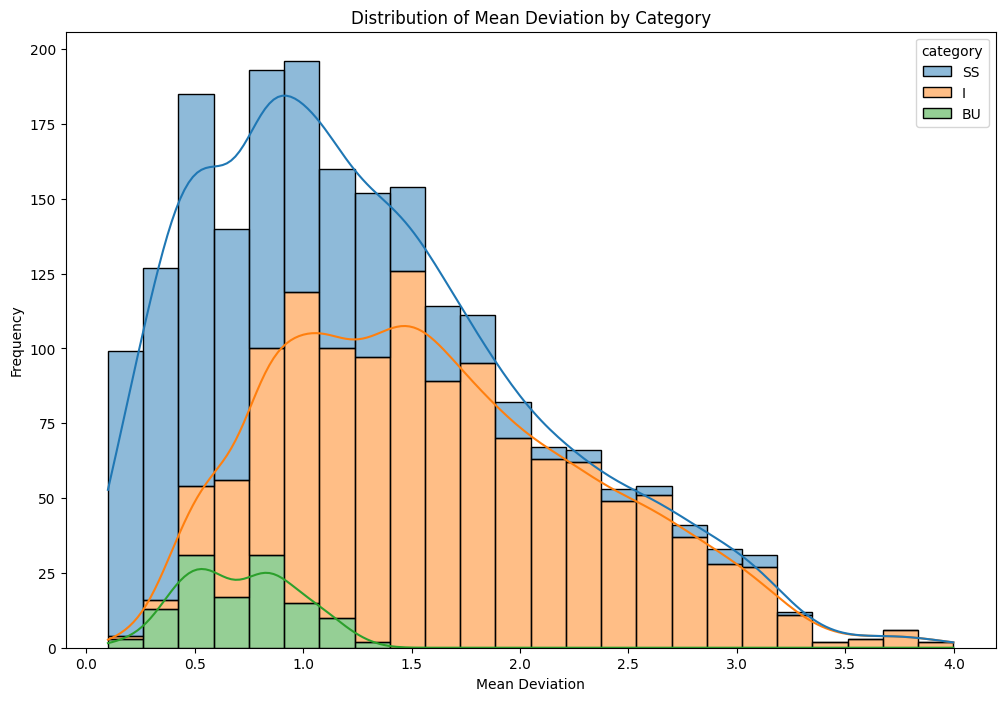

In [12]:
# Plot the distribution of 'mean_deviation' for each category
plt.figure(figsize=(12, 8))
df_class = df_class[df_class["std_deviation"] > 0.1]
sns.histplot(data=df_class, x='std_deviation', hue='category', multiple='stack', kde=True)
plt.xlabel('Mean Deviation')
plt.ylabel('Frequency')
plt.title('Distribution of Mean Deviation by Category')
plt.show()

In [4]:
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=df_class['A'], y=df_class['B'], hue=df_class["category"])
# plt.xlabel('A')
# plt.ylabel('B')
# plt.title('Scatter plot of A vs B for Sampling Centers')
# plt.show()

fig = px.scatter(
    df_class,
    x="A",
    y="B",
    color="category",
    title="Scatter plot of A vs B",
    labels={"A": "A", "B": "B"},
    width=800,
    height=800,
)

# Display the plot in the notebook
fig.show()


In [5]:
df_class.value_counts("category")

category
SS    4195
I     2881
BU     124
Name: count, dtype: int64

In [32]:
df_class["op"] = df_class["original_point"].astype(str)
for _, df1 in df_class.groupby("op"):
    original_point = df1.iloc[0]["original_point"]
    print(original_point, df1.value_counts("category").to_dict())

{'A': 0.5, 'B': 0.625, 'Du': 1, 'Dv': 11} {'SS': 60}
{'A': 0.5, 'B': 0.625, 'Du': 1, 'Dv': 18} {'SS': 60}
{'A': 0.5, 'B': 0.625, 'Du': 1, 'Dv': 4} {'SS': 60}
{'A': 0.5, 'B': 0.625, 'Du': 3, 'Dv': 12} {'SS': 60}
{'A': 0.5, 'B': 0.625, 'Du': 3, 'Dv': 33} {'SS': 60}
{'A': 0.5, 'B': 0.625, 'Du': 3, 'Dv': 54} {'SS': 60}
{'A': 0.5, 'B': 1.0, 'Du': 1, 'Dv': 11} {'SS': 60}
{'A': 0.5, 'B': 1.0, 'Du': 1, 'Dv': 18} {'SS': 60}
{'A': 0.5, 'B': 1.0, 'Du': 1, 'Dv': 4} {'SS': 60}
{'A': 0.5, 'B': 1.0, 'Du': 3, 'Dv': 12} {'SS': 60}
{'A': 0.5, 'B': 1.0, 'Du': 3, 'Dv': 33} {'SS': 60}
{'A': 0.5, 'B': 1.0, 'Du': 3, 'Dv': 54} {'SS': 60}
{'A': 0.5, 'B': 1.5, 'Du': 1, 'Dv': 11} {'SS': 55, 'BU': 4, 'I': 1}
{'A': 0.5, 'B': 1.5, 'Du': 1, 'Dv': 18} {'SS': 36, 'I': 13, 'BU': 11}
{'A': 0.5, 'B': 1.5, 'Du': 1, 'Dv': 4} {'SS': 51, 'BU': 9}
{'A': 0.5, 'B': 1.5, 'Du': 3, 'Dv': 12} {'SS': 42, 'BU': 18}
{'A': 0.5, 'B': 1.5, 'Du': 3, 'Dv': 33} {'SS': 49, 'BU': 11}
{'A': 0.5, 'B': 1.5, 'Du': 3, 'Dv': 54} {'SS': 42, 'BU': 13

In [7]:
def plot_ball_behavior(df, metric="dev"):
    t = np.linspace(0, 100, 100)
    title = ""

    all_metrics = []
    for _, row in df.iterrows():
        d = get_data(row)
        metrics = compute_metrics(row, start_frame=0)
        if metric == "dev":
            title = "Deviation"
            values = metrics[0]
        elif metric == "dt":
            title = "Time Derivative"
            values = metrics[1]
        elif metric == "dx":
            title = "Spatial Derivative"
            values = metrics[2]
        all_metrics.append(values)
    
    # Convert to numpy array for easier computation
    all_metrics = np.array(all_metrics)

    # Compute mean and std
    avg_metric = np.mean(all_metrics, axis=0)
    std_metric = np.std(all_metrics, axis=0)

    # Create figure
    fig = go.Figure()

    # Add shaded area for standard deviation
    fig.add_trace(
        go.Scatter(
            x=np.concatenate([t, t[::-1]]),
            y=np.concatenate(
                [avg_metric + std_metric, (avg_metric - std_metric)[::-1]]
            ),
            fill="toself",
            fillcolor="rgba(0,100,80,0.2)",
            line=dict(color="rgba(255,255,255,0)"),
            showlegend=False,
        )
    )

    # Add mean line
    fig.add_trace(
        go.Scatter(
            x=t,
            y=avg_metric,
            mode="lines",
            name=title,
            hovertemplate="Index: %{x}<br>Deviation: %{y:.2f}<extra></extra>",
        )
    )

    # Update layout
    fig.update_layout(
        title="Deviation Metrics",
        xaxis_title="Time Step/Index",
        yaxis_title="Deviation Value",
        hovermode="x unified",
        showlegend=True,
        template="plotly_white",
    )

    fig.show()


In [37]:
df1 = df_class[df_class["op"] == "{'A': 2.0, 'B': 8.0, 'Du': 3, 'Dv': 12}"]
len(df1)

60

In [38]:
plot_ball_behavior(df1)

In [10]:
df1["ic"] = df1["initial_condition"].astype(str)
fig = px.scatter(
    df1,
    x="Du",
    y="Dv",
    color="ic",
    title="Scatter plot of A vs B",
    width=800,
    height=800,
)

# Display the plot in the notebook
fig.show()

/scratch/tmp.24266182.vogtva/ipykernel_3709971/608294727.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [42]:
df1_filt.to_csv("mix.csv", index=False)

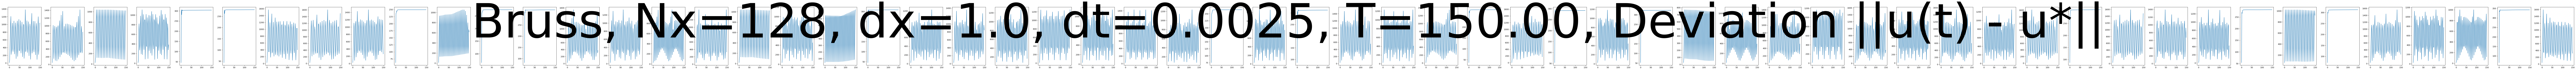

array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

In [41]:
df1_filt = df1
metrics_grid(df1_filt, 0, var1="")

In [20]:
df_class = classify_trajectories(
    df1_filt.iloc[:1], steady_threshold=1, osc_threshold=1.28, dev_threshold=1.28
)
df1_filt.loc[0]

/cluster/home/vogtva/pde-solvers-cuda/analysis/classify.py:133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



KeyError: 0